# Лабораторная работа 4: Оптимизаторы и регуляризация (Dropout)

 ## Импорт библиотек и константы

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Константы
SEED = 42
EPOCHS = 500        # Для синтетических данных
EPOCHS_MNIST = 8    # Для MNIST (достаточно меньше эпох, т.к. датасет большой)
LEARNING_RATE = 0.01
HIDDEN_SIZE = 32    # Увеличим скрытый слой

torch.manual_seed(SEED)
np.random.seed(SEED)


## Часть 1: Синтетические данные 

### 1. Генерация и визуализация данных (Задания 1-2)

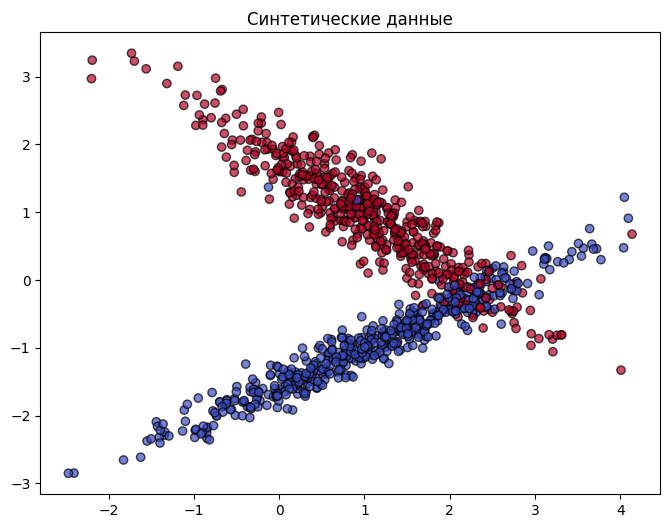

In [38]:
# 1. Генерация данных
X, y = make_classification(
    n_samples=1000, 
    n_features=2, 
    n_informative=2, 
    n_redundant=0, 
    n_clusters_per_class=1, 
    random_state=SEED
)

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Преобразование в тензоры
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)

# Визуализация
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k', alpha=0.7)
plt.title("Синтетические данные")
plt.show()

 ### 2. Создание MLP 

In [39]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, use_dropout=False, dropout_prob=0.5):
        super(MLP, self).__init__()
        
        self.use_dropout = use_dropout
        
        # Слой 1
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        
        # Dropout (если включен)
        self.dropout = nn.Dropout(p=dropout_prob)
        
        # Слой 2 (Выходной)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        # Для бинарной классификации (выход 1) нужен Sigmoid в конце
        # Для многоклассовой (MNIST, выход 10) Sigmoid/Softmax обычно не ставят внутрь модели при использовании CrossEntropyLoss
        self.is_binary = (output_dim == 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        
        if self.use_dropout:
            out = self.dropout(out)
            
        out = self.fc2(out)
        
        if self.is_binary:
            out = self.sigmoid(out)
        return out


### 3. Функция для эксперимента с оптимизаторами

In [40]:
def train_experiment(model, X_train, y_train, optimizer_name, epochs, lr=0.01):
    criterion = nn.BCELoss() # Binary Cross Entropy
    
    # Выбор оптимизатора по имени
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'RMSProp':
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    else:
        raise ValueError("Unknown optimizer")
        
    loss_history = []
    
    model.train() # Включаем режим обучения (важно для Dropout!)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        
    return loss_history

### 4. Исследование оптимизаторов (Без Dropout)

--- Результаты (Без Dropout) ---
Оптимизатор: SGD | Accuracy: 0.8950 | Final Loss: 0.2656
Оптимизатор: Adam | Accuracy: 0.9300 | Final Loss: 0.1234
Оптимизатор: RMSProp | Accuracy: 0.9450 | Final Loss: 0.1283


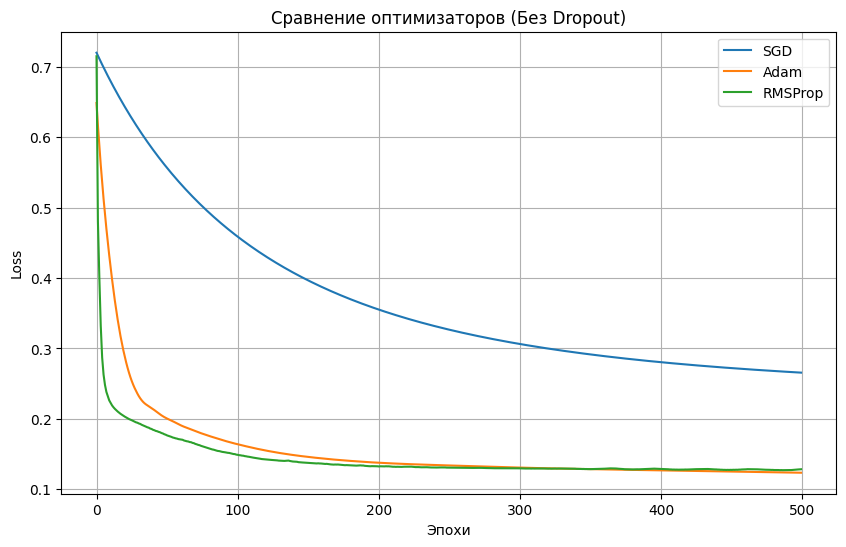

In [41]:
optimizers_list = ['SGD', 'Adam', 'RMSProp']
results = {}

plt.figure(figsize=(10, 6))

print("--- Результаты (Без Dropout) ---")

for opt_name in optimizers_list:
    # Создаем новую модель для каждого запуска
    model = MLP(input_dim=2, hidden_dim=HIDDEN_SIZE, output_dim=1, use_dropout=False)
    
    # Обучаем
    losses = train_experiment(model, X_train_tensor, y_train_tensor, opt_name, EPOCHS, LEARNING_RATE)
    results[opt_name] = model # Сохраняем модель
    
    # Оценка
    model.eval()
    with torch.no_grad():
        preds = model(X_test_tensor)
        preds_cls = (preds > 0.5).float()
        acc = accuracy_score(y_test, preds_cls)
    
    print(f"Оптимизатор: {opt_name} | Accuracy: {acc:.4f} | Final Loss: {losses[-1]:.4f}")
    
    # График
    plt.plot(losses, label=opt_name)

plt.title("Сравнение оптимизаторов (Без Dropout)")
plt.xlabel("Эпохи")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

### 5. Исследование оптимизаторов(с Dropout)


--- Результаты (C Dropout p=0.2) ---
Оптимизатор: SGD | Accuracy: 0.8850 | Final Loss: 0.2873
Оптимизатор: Adam | Accuracy: 0.9400 | Final Loss: 0.1260
Оптимизатор: RMSProp | Accuracy: 0.9450 | Final Loss: 0.1244


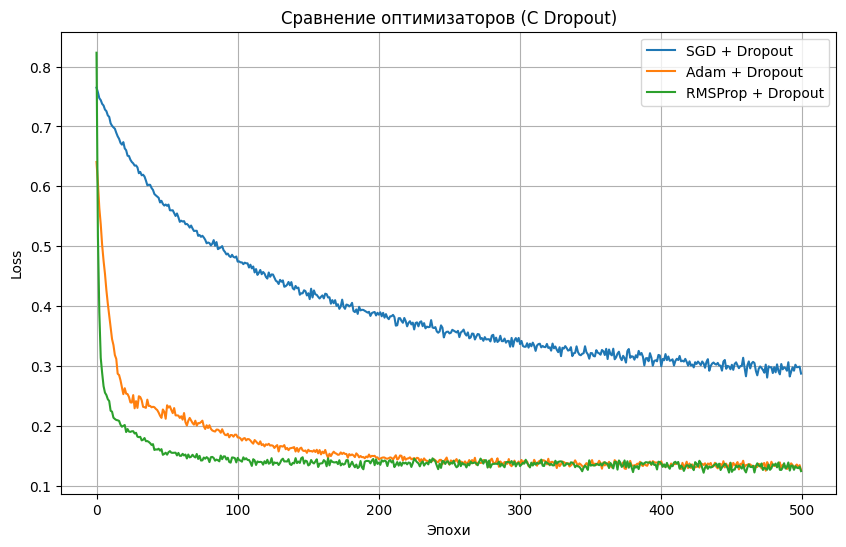

In [42]:
plt.figure(figsize=(10, 6))

print("\n--- Результаты (C Dropout p=0.2) ---")

for opt_name in optimizers_list:
    # Включаем Dropout
    model = MLP(input_dim=2, hidden_dim=HIDDEN_SIZE, output_dim=1, use_dropout=True, dropout_prob=0.2)
    
    losses = train_experiment(model, X_train_tensor, y_train_tensor, opt_name, EPOCHS, LEARNING_RATE)
    
    model.eval() # Важно! Отключает dropout для теста
    with torch.no_grad():
        preds = model(X_test_tensor)
        preds_cls = (preds > 0.5).float()
        acc = accuracy_score(y_test, preds_cls)
    
    print(f"Оптимизатор: {opt_name} | Accuracy: {acc:.4f} | Final Loss: {losses[-1]:.4f}")
    
    plt.plot(losses, label=f"{opt_name} + Dropout")

plt.title("Сравнение оптимизаторов (C Dropout)")
plt.xlabel("Эпохи")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

## Часть 2: MNIST

### 1. Загрузка MNIST

In [43]:
# 1. Загрузка MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Скачиваем данные (если не скачаны)
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# DataLoader (для пакетного обучения - batch training, так как данных много)
BATCH_SIZE = 64
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

### 2. Функция обучения для MNIST

In [44]:
def train_mnist(model, loader, optimizer_name, epochs, lr=0.001):
    criterion = nn.CrossEntropyLoss() # Для многоклассовой классификации
    
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr) # Для SGD на MNIST часто нужен lr повыше или momentum
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'RMSProp':
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
        
    loss_history = []
    
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(loader, 0):
            inputs, labels = data
            # Выпрямляем картинку: [64, 1, 28, 28] -> [64, 784]
            inputs = inputs.view(-1, 28*28) 
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Средний лосс за эпоху
        avg_loss = running_loss / len(loader)
        loss_history.append(avg_loss)
        print(f"[{optimizer_name}] Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
        
    return loss_history

### 3. Эксперименты на MNIST

In [45]:
mnist_opts = ['SGD', 'Adam', 'RMSProp']
dropout_settings = [False, True]

# Словарь для сохранения результатов, чтобы потом строить графики без переобучения
mnist_results = {}

for opt_name in mnist_opts:
    for use_drop in dropout_settings:
        drop_str = "Dropout" if use_drop else "No Drop"
        print(f"Training {opt_name} with {drop_str}...")
        
        # Вход 784, Скрытый 128, Выход 10
        model = MLP(input_dim=784, hidden_dim=128, output_dim=10, use_dropout=use_drop, dropout_prob=0.2)
        
        # Используем LR=0.001 (стандарт для Adam), для SGD это может быть маловато, но позволит сравнить "как есть"
        losses = train_mnist(model, trainloader, opt_name, EPOCHS_MNIST, lr=0.001)
        
        # СОХРАНЯЕМ результат в словарь
        mnist_results[(opt_name, use_drop)] = losses
        
        # Тест точности
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images = images.view(-1, 28*28)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        print(f"  -> Accuracy: {100 * correct / total:.2f}%")

Training SGD with No Drop...
[SGD] Epoch 1/8, Loss: 1.9095
[SGD] Epoch 2/8, Loss: 1.2177
[SGD] Epoch 3/8, Loss: 0.8493
[SGD] Epoch 4/8, Loss: 0.6775
[SGD] Epoch 5/8, Loss: 0.5832
[SGD] Epoch 6/8, Loss: 0.5241
[SGD] Epoch 7/8, Loss: 0.4839
[SGD] Epoch 8/8, Loss: 0.4546
  -> Accuracy: 88.90%
Training SGD with Dropout...
[SGD] Epoch 1/8, Loss: 1.9501
[SGD] Epoch 2/8, Loss: 1.3132
[SGD] Epoch 3/8, Loss: 0.9391
[SGD] Epoch 4/8, Loss: 0.7572
[SGD] Epoch 5/8, Loss: 0.6563
[SGD] Epoch 6/8, Loss: 0.5914
[SGD] Epoch 7/8, Loss: 0.5471
[SGD] Epoch 8/8, Loss: 0.5162
  -> Accuracy: 88.99%
Training Adam with No Drop...
[Adam] Epoch 1/8, Loss: 0.3886
[Adam] Epoch 2/8, Loss: 0.2076
[Adam] Epoch 3/8, Loss: 0.1486
[Adam] Epoch 4/8, Loss: 0.1196
[Adam] Epoch 5/8, Loss: 0.0998
[Adam] Epoch 6/8, Loss: 0.0864
[Adam] Epoch 7/8, Loss: 0.0795
[Adam] Epoch 8/8, Loss: 0.0713
  -> Accuracy: 97.11%
Training Adam with Dropout...
[Adam] Epoch 1/8, Loss: 0.4228
[Adam] Epoch 2/8, Loss: 0.2275
[Adam] Epoch 3/8, Loss: 0.

### 4. Визуализация результатов

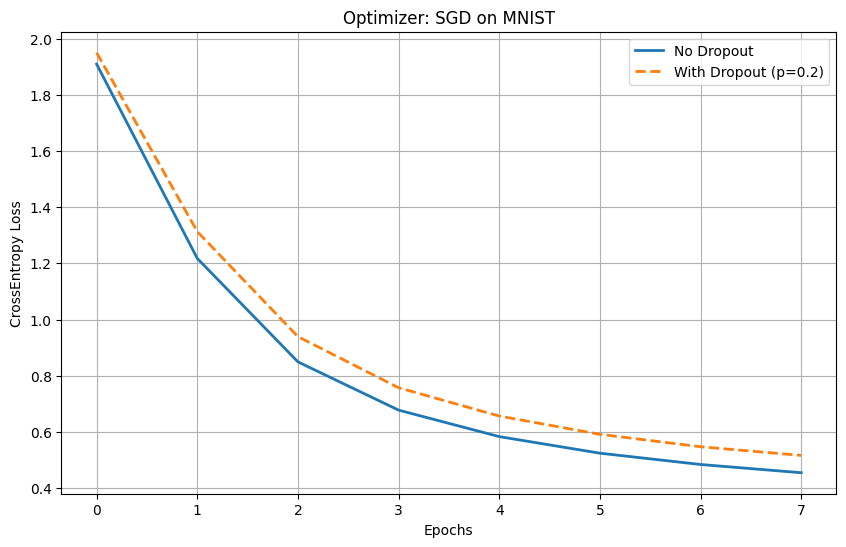

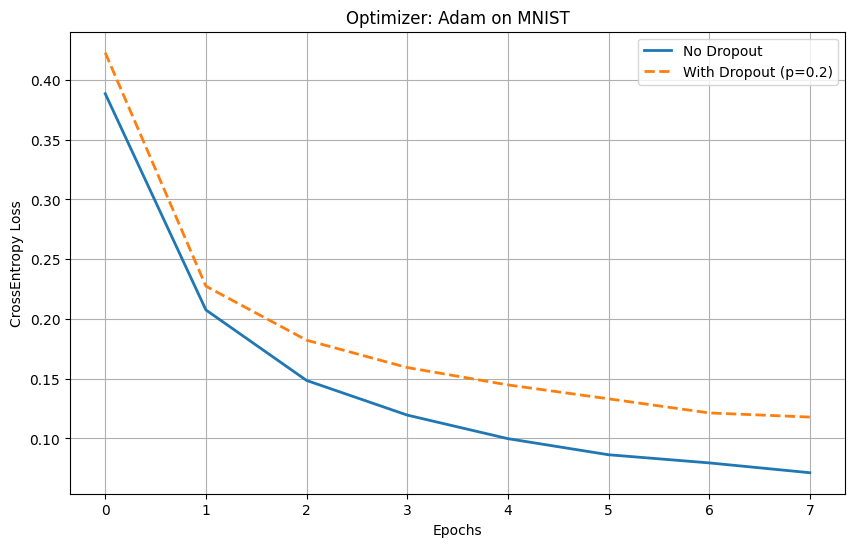

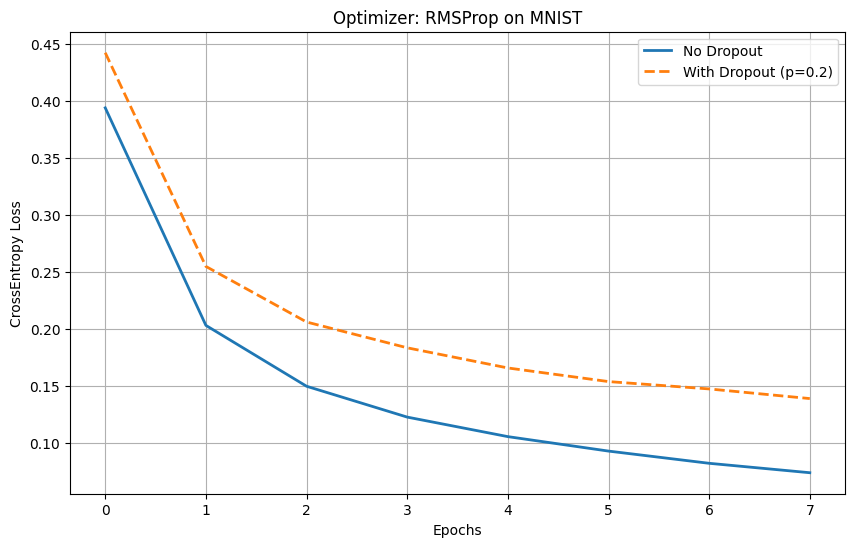

In [46]:
for opt_name in mnist_opts:
    plt.figure(figsize=(10, 6))
    
    # Достаем сохраненные данные из словаря
    # График БЕЗ Dropout
    loss_no_drop = mnist_results[(opt_name, False)]
    plt.plot(loss_no_drop, label="No Dropout", linestyle='-', linewidth=2)
    
    # График С Dropout
    loss_drop = mnist_results[(opt_name, True)]
    plt.plot(loss_drop, label="With Dropout (p=0.2)", linestyle='--', linewidth=2)
    
    plt.title(f"Optimizer: {opt_name} on MNIST")
    plt.xlabel("Epochs")
    plt.ylabel("CrossEntropy Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

## Выводы

### 1. Оптимизаторы

- **SGD** справился хуже всех (~89.5%). Он учится медленно и неуверенно.
    
- **Adam и RMSProp** показали отличный результат (~93-94%). Они быстрее находят верное решение.
    

### 2. Dropout

- Для **Adam** Dropout сработал как надо: точность выросла (с 93% до 94%).
    
- Для **SGD** Dropout сделал только хуже. Слабому оптимизатору сложно учиться, когда нейроны постоянно отключаются.
    

## Часть 2: MNIST (распознавание цифр)

### 1. Скорость обучения

- **Adam и RMSProp** — явные лидеры. Уже на первых эпохах они дают высокую точность (~97%).
    
- **SGD** сильно отстает. Ему нужно гораздо больше времени, чтобы хотя бы приблизиться к результатам остальных (достиг только ~89%).
    

### 2. Влияние Dropout на MNIST

- В этом эксперименте Dropout **не дал прироста точности** (результат даже чуть ниже).
    
- **Причина в малом количестве эпох.** Мы обучали всего 8 эпох. На короткой дистанции модель просто не успела раскрыть потенциал регуляризации.
    